# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

In [52]:
import pandas as pd
import essentia
import essentia.standard as estd
import matplotlib.pyplot as plt
from IPython.display import display, Audio

## Experiment 1: Audio mosaicing with similar timbre (using spectral features)

In [53]:
def analyze_sound(audio_path, frame_size=None, audio_id=None):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will 
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as 
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be 
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file
    

    
    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()
    

    # Some processing of frame_size parameter to avoid later problems
    if frame_size is None:
        frame_size = len(audio)  # If no frame_size is given use no frames (analyze all audio at once)
    if frame_size % 2 != 0:
        frame_size = frame_size + 1 # Make frame size even

                
        
    
    
    # Calculate the start and end samples for each equally-spaced audio frame
    frame_start_samples = range(0, len(audio), frame_size)
    frame_start_end_samples = zip(frame_start_samples[:-1], frame_start_samples[1:])
    
    # Iterate over audio frames and analyze each one
    for count, (fstart, fend) in enumerate(frame_start_end_samples):
        
        # Get corresponding audio chunk and initialize dictionary to sotre analysis results with some basic metadata
        frame = audio[fstart:fend]

        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, count),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }
        
        # Extract loudness
        loudness_algo = estd.Loudness()
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        
        
        # Extract MFCC coefficients

        w_algo = estd.Windowing(type = 'hann')# different kinds of signals need different para
        spectrum_algo = estd.Spectrum()
        mfcc_algo = estd.MFCC()
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
        
        # Extract other features here and add to 'frame_output' dictionary
        # Spectro centroid
        Spec_centroid_algo = estd.SpectralCentroidTime()
        frame_output["spec_centroid"] = Spec_centroid_algo(frame)
        #frame_output["spectral_centroid"] = features['lowlevel.spectral_centroid.mean']
        
        # Energy
        energy_algo = estd.Energy()
        energy = energy_algo(frame)
        frame_output["energy"] = energy

        # Extract Tonality information
        key_algo = estd.KeyExtractor()
        key, scale, key_strength = key_algo(frame)
        frame_output["key"] = key
        frame_output["scale"] = scale
        frame_output["key_strength"] = key_strength

        
        # Add frame analysis results to output
        analysis_output.append(frame_output)

    return analysis_output
    

## Analyze source collection Experiment1 frame_size = 1/16note

In [54]:
DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME = 'dataframe_source_exp1_16th.csv'  # DataFrame file where to store the results of our analysis
TARGET_SOUND_PATH = 'edited_MISSION.wav'
# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME), index_col=0)
analyses = []

loader = estd.MonoLoader(filename=TARGET_SOUND_PATH)
audio = loader()
# Calculate BPM 
bpm_algo = estd.RhythmExtractor()
bpm, _, _, _ = bpm_algo(audio)
print(bpm)

framesize = int(round(float(60/bpm)*44100) /4)# 1/16 note
print(framesize)
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    analysis_output = analyze_sound(sound['path'], frame_size=framesize, audio_id=sound['freesound_id'])  # Split audio in chunks of 200ms (44100/5 samples)
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame


100.48737335205078
6583
Analyzing sound with id 469308 [1/40]
Analyzing sound with id 100759 [2/40]
Analyzing sound with id 220662 [3/40]
Analyzing sound with id 503020 [4/40]
Analyzing sound with id 436782 [5/40]
Analyzing sound with id 85897 [6/40]
Analyzing sound with id 509882 [7/40]
Analyzing sound with id 509885 [8/40]
Analyzing sound with id 220820 [9/40]
Analyzing sound with id 551019 [10/40]
Analyzing sound with id 25602 [11/40]
Analyzing sound with id 509486 [12/40]
Analyzing sound with id 42551 [13/40]
Analyzing sound with id 102785 [14/40]
Analyzing sound with id 132582 [15/40]
Analyzing sound with id 265677 [16/40]
Analyzing sound with id 278984 [17/40]
Analyzing sound with id 410149 [18/40]
Analyzing sound with id 218279 [19/40]
Analyzing sound with id 208871 [20/40]
Analyzing sound with id 82238 [21/40]
Analyzing sound with id 524882 [22/40]
Analyzing sound with id 112462 [23/40]
Analyzing sound with id 154726 [24/40]
Analyzing sound with id 128972 [25/40]
Analyzing soun

,end_sample,energy,freesound_id,id,key,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,spec_centroid,start_sample
0,6584,90.722755,469308,469308_f0,F,0.568912,3.113007e-03,-641.969604,46.488136,-28.238220,...,-35.310890,-11.983912,-62.688850,21.610577,-0.045610,-39.021896,files/469308_2927958-hq.ogg,major,2936.839600,0
1,13168,1.690009,469308,469308_f1,F,0.647343,2.158718e-04,-906.854492,36.727539,-9.252567,...,-16.474197,11.143658,-36.977306,-9.084049,49.574688,-32.811424,files/469308_2927958-hq.ogg,minor,2453.164795,6584
2,19752,0.239204,469308,469308_f2,Eb,0.873726,5.824846e-05,-988.790588,80.408844,-16.249697,...,3.282669,20.870361,-30.387787,-11.976814,21.625294,-32.952896,files/469308_2927958-hq.ogg,minor,3290.964844,13168
3,26336,0.093487,469308,469308_f3,C,0.739637,3.103947e-05,-1008.720764,101.729439,-16.129675,...,-0.385132,10.658966,-9.064896,-6.071793,3.405102,-8.127609,files/469308_2927958-hq.ogg,major,1272.567871,19752
4,6584,184.744507,100759,100759_f0,C,0.612620,5.013178e-03,-681.142090,113.231659,-7.620169,...,-37.447624,-29.608467,-39.349346,-14.582453,-25.271008,-10.093330,files/100759_321967-hq.ogg,major,1476.714478,0
5,13168,80.589813,100759,100759_f1,F,0.509265,2.875530e-03,-695.609497,29.433653,18.843439,...,-42.352226,-69.001305,-25.111937,-3.621229,18.717350,0.733242,files/100759_321967-hq.ogg,major,2516.654053,6584
6,19752,0.415378,100759,100759_f2,C#,0.697338,8.430767e-05,-1002.487732,11.995922,-12.897228,...,-13.318703,2.594734,6.860481,13.169062,18.191250,-16.844448,files/100759_321967-hq.ogg,minor,1996.503906,13168
7,6584,0.522618,220662,220662_f0,F#,0.280413,9.833177e-05,-1087.503906,28.626995,9.364079,...,-6.165955,13.374352,12.629612,-1.628601,12.132931,34.235474,files/220662_3824909-hq.ogg,minor,2279.289551,0
8,13168,577.893188,220662,220662_f1,F,0.392489,1.076337e-02,-696.694092,0.945787,1.363146,...,-27.689068,6.959274,31.583765,47.576530,40.199776,41.783043,files/220662_3824909-hq.ogg,major,1083.144409,6584
9,19752,9.401878,220662,220662_f2,Eb,0.677222,6.816540e-04,-997.560486,102.207947,37.014339,...,-40.281624,-7.819908,17.514896,18.740931,26.612003,42.156204,files/220662_3824909-hq.ogg,minor,865.080383,13168


,end_sample,energy,freesound_id,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,spec_centroid,start_sample
count,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,30804.778281,224.990317,287366.239819,0.281443,0.003609,-938.899143,77.828439,1.080702,0.472751,-0.899499,-10.126627,3.424564,0.357188,4.485049,2.201335,2.467725,-0.296391,-0.117730,1184.936043,24220.778281
std,21159.276229,580.230503,174108.004983,0.634775,0.006899,195.408818,67.274277,14.029867,13.688558,10.697729,54.306306,36.573345,30.296145,20.841859,19.213640,14.925104,14.997876,17.144789,1265.937292,21159.276229
min,6584.000000,0.000000,25602.000000,-1.000000,0.000000,-1138.420044,-30.704071,-28.405361,-41.536461,-36.679604,-206.472397,-97.189552,-102.735237,-80.218964,-62.688850,-46.331734,-64.849289,-74.427788,0.000000,0.000000
25%,13168.000000,0.004784,151822.000000,0.384003,0.000004,-1123.040527,7.467632,-6.295874,-5.605232,-5.872892,-38.286999,-13.433010,-13.769566,-4.223198,-6.360168,-3.947731,-6.067871,-7.263008,206.837555,6584.000000
50%,26336.000000,2.576455,265677.000000,0.535288,0.000286,-1003.797913,70.227608,-0.000027,-0.000031,-0.000038,-0.000061,0.000080,-0.000061,0.036079,-0.000027,-0.000053,-0.000046,-0.000023,903.219482,19752.000000
75%,46088.000000,144.438919,503020.000000,0.655751,0.004251,-776.276184,126.616005,5.320404,5.834007,2.747086,26.647190,24.511120,20.206116,16.176060,13.759083,9.714762,4.825939,7.987575,1635.045044,39504.000000
max,85592.000000,3624.510254,556814.000000,0.914818,0.036830,-472.791718,269.459991,57.369015,45.612144,33.815136,126.327393,132.428360,95.571045,59.443787,54.148796,50.096245,49.574688,45.758095,8026.957520,79008.000000


## Analyze source collection Experiment1 frame_size = 1/8 note

In [55]:
DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME = 'dataframe_source_exp1_8th.csv'  # DataFrame file where to store the results of our analysis
TARGET_SOUND_PATH = 'edited_MISSION.wav'
# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME), index_col=0)
analyses = []

loader = estd.MonoLoader(filename=TARGET_SOUND_PATH)
audio = loader()
# Calculate BPM 
bpm_algo = estd.RhythmExtractor()
bpm, _, _, _ = bpm_algo(audio)
print(bpm)

framesize = int(round(float(60/bpm)*44100) /2)# frame_size = 1/8 note
print(framesize)
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    analysis_output = analyze_sound(sound['path'], frame_size=framesize, audio_id=sound['freesound_id'])  # Split audio in chunks of 200ms (44100/5 samples)
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame


100.48737335205078
13166
Analyzing sound with id 469308 [1/40]
Analyzing sound with id 100759 [2/40]
Analyzing sound with id 220662 [3/40]
Analyzing sound with id 503020 [4/40]
Analyzing sound with id 436782 [5/40]
Analyzing sound with id 85897 [6/40]
Analyzing sound with id 509882 [7/40]
Analyzing sound with id 509885 [8/40]
Analyzing sound with id 220820 [9/40]
Analyzing sound with id 551019 [10/40]
Analyzing sound with id 25602 [11/40]
Analyzing sound with id 509486 [12/40]
Analyzing sound with id 42551 [13/40]
Analyzing sound with id 102785 [14/40]
Analyzing sound with id 132582 [15/40]
Analyzing sound with id 265677 [16/40]
Analyzing sound with id 278984 [17/40]
Analyzing sound with id 410149 [18/40]
Analyzing sound with id 218279 [19/40]
Analyzing sound with id 208871 [20/40]
Analyzing sound with id 82238 [21/40]
Analyzing sound with id 524882 [22/40]
Analyzing sound with id 112462 [23/40]
Analyzing sound with id 154726 [24/40]
Analyzing sound with id 128972 [25/40]
Analyzing sou

,end_sample,energy,freesound_id,id,key,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,spec_centroid,start_sample
0,13166,9.241216e+01,469308,469308_f0,F,0.451076,1.576103e-03,-752.813293,57.777905,-34.281906,...,-41.925472,-10.845659,-61.840881,9.660812,16.175175,-31.300705,files/469308_2927958-hq.ogg,minor,2928.709473,0
1,26332,3.328524e-01,469308,469308_f1,Eb,0.899236,3.634584e-05,-1035.013794,81.075844,-20.663290,...,8.252731,15.338356,-5.910378,-5.086441,3.175907,-12.578789,files/469308_2927958-hq.ogg,major,2870.980469,13166
2,13166,2.653339e+02,100759,100759_f0,E,0.470652,3.195121e-03,-644.135254,79.004578,5.320717,...,-29.814779,-32.949608,-34.745621,-29.090897,0.597782,-7.363062,files/100759_321967-hq.ogg,minor,1856.306396,0
3,13166,5.783620e+02,220662,220662_f0,F,0.441134,5.385425e-03,-786.371643,6.374660,-7.748795,...,-33.850822,-0.075577,24.742052,36.495926,32.706005,32.362762,files/220662_3824909-hq.ogg,minor,1084.874268,0
4,13166,1.297540e+01,503020,503020_f0,D,0.710677,4.229968e-04,-959.654236,156.219727,19.423313,...,-46.968391,-3.087166,5.837299,-2.307365,-5.402603,6.913088,files/503020_3953729-hq.ogg,major,820.253967,0
5,26332,8.230229e+00,503020,503020_f1,E,0.526680,3.117972e-04,-965.016663,160.263947,23.328724,...,-58.302071,-7.628181,10.896641,3.204536,-8.255028,1.689362,files/503020_3953729-hq.ogg,minor,814.661316,13166
6,39498,1.712525e-01,503020,503020_f2,C,0.521949,2.328535e-05,-1082.679077,62.201363,2.809269,...,-19.990307,-12.749763,-1.595516,3.089455,2.291027,1.762131,files/503020_3953729-hq.ogg,major,815.152832,26332
7,52664,9.742029e+00,503020,503020_f3,D,0.394234,3.490931e-04,-963.734741,128.382996,7.005932,...,-4.767929,2.631172,-3.139492,12.553934,7.505260,-6.940376,files/503020_3953729-hq.ogg,major,1062.803345,39498
8,65830,2.665397e+00,503020,503020_f4,E,0.598732,1.464895e-04,-1001.666016,116.867165,5.610348,...,-8.363632,13.594864,8.434879,4.303421,1.750534,-0.862862,files/503020_3953729-hq.ogg,major,1040.954468,52664
9,13166,5.961295e+00,436782,436782_f0,A,0.804987,2.512027e-04,-907.241821,147.549347,2.063580,...,11.656418,-11.182365,-7.285583,8.332438,1.946335,2.906898,files/436782_4347097-hq.ogg,minor,1297.615601,0


,end_sample,energy,freesound_id,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,spec_centroid,start_sample
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,33114.484848,488.529123,289286.828283,0.314007,0.003301,-941.152584,83.183357,-0.375902,-0.855255,-1.238574,-9.186491,3.565641,-0.858807,2.621223,1.576395,1.270646,-0.239770,-1.022040,1220.258031,19948.484848
std,19488.769405,1006.885377,173524.102245,0.595830,0.005232,183.890238,67.932584,12.781118,12.546766,9.310932,55.765584,37.387772,32.503368,21.093944,19.314970,15.133610,13.272673,15.086383,1231.282699,19488.769405
min,13166.000000,0.000000,25663.000000,-1.000000,0.000000,-1138.420044,-11.696808,-34.281906,-32.551605,-29.409740,-204.198120,-83.010414,-94.980164,-73.006897,-61.840881,-45.336235,-52.396935,-53.003029,0.000000,0.000000
25%,13166.000000,0.052580,151822.000000,0.398428,0.000011,-1119.239319,17.818966,-7.780098,-6.938412,-6.218457,-35.220182,-12.102425,-16.917643,-5.579817,-6.781240,-2.809074,-5.258259,-8.265610,348.124817,0.000000
50%,26332.000000,12.975398,265677.000000,0.521949,0.000423,-997.898499,77.520668,-0.000027,-0.000031,-0.000038,-0.000061,0.000080,-0.000061,0.000023,-0.000027,-0.000053,-0.000046,-0.000023,1002.208984,13166.000000
75%,39498.000000,544.285950,486164.000000,0.640806,0.005171,-786.358459,144.368484,4.528765,4.576067,1.901030,24.135790,22.024482,19.459122,13.741570,13.934803,8.716578,5.203917,5.855426,1671.675537,26332.000000
max,78996.000000,4887.902832,556814.000000,0.939932,0.022504,-536.718506,219.247284,48.261593,42.770454,31.050457,130.679077,137.474121,95.957214,61.297729,49.928093,40.112804,32.943249,39.002518,8049.093262,65830.000000


## Analyze the target sound file Experiment 1

I apply the code to make the reconstruction of the sound synchronous to the beat of the target signal.

In [56]:
def analyze_Target_sound(audio_path, frame_size_type=None, audio_id=None):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will 
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as 
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be 
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file
    

    
    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()
    
    # Make the reconstruction of the sound synchronous to the beat of the target signal.
    beat_tracker_algo = estd.BeatTrackerDegara()
    beat_positions = beat_tracker_algo(audio)
    beat_positions = [int(round(position * 44100)) for position in beat_positions]
    

    # Calculate the start and end samples
    beat_start_samples = beat_positions
    beat_start_end_samples = zip(beat_start_samples[:-1], beat_start_samples[1:])
    new_frame_start_samples = []
    
#     if frame_size is None:
#         frame_size = len(audio)  # If no frame_size is given use no frames (analyze all audio at once)
#     if frame_size % 2 != 0:
#         frame_size = frame_size + 1 # Make frame size even
    if frame_size_type == "eighth":
        # generate 1/8 note beat posistion
        for count, (bstart,bend) in enumerate(beat_start_end_samples):
            half_position = round((bend-bstart)/2.0)
            new_frame_start_samples.append(bstart)
            new_frame_start_samples.append(bstart+half_position)
        # print(new_frame_start_samples)
        new_frame_start_end_samples = zip(new_frame_start_samples[:-1],new_frame_start_samples[1:])
    if frame_size_type == "sixteenth":
        # generate 1/16 note beat posistion
        for count, (bstart,bend) in enumerate(beat_start_end_samples):
            half_position = round((bend-bstart)/4.0)
            new_frame_start_samples.append(bstart)
            new_frame_start_samples.append(bstart+half_position)
            new_frame_start_samples.append(bstart+2*half_position)
            new_frame_start_samples.append(bstart+3*half_position)
        # print(new_frame_start_samples)
        new_frame_start_end_samples = zip(new_frame_start_samples[:-1],new_frame_start_samples[1:])
    
    
    # Iterate over audio frames and analyze each one
    for count, (fstart, fend) in enumerate(new_frame_start_end_samples):
        #print("beat length",fend-fstart)
        # Get corresponding audio chunk and initialize dictionary to sotre analysis results with some basic metadata
        frame = audio[fstart:fend]

        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, count),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }
        
        # Extract loudness
        loudness_algo = estd.Loudness()
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame
        
        # Extract MFCC coefficients

        w_algo = estd.Windowing(type = 'hann')# different kinds of signals need different para
        spectrum_algo = estd.Spectrum()
        mfcc_algo = estd.MFCC()
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
        
        # Extract other features here and add to 'frame_output' dictionary
        # Energy
        energy_algo = estd.Energy()
        energy = energy_algo(frame)
        frame_output["energy"] = energy
        
        # Spectro centroid
        Spec_centroid_algo = estd.SpectralCentroidTime()
        frame_output["spec_centroid"] = Spec_centroid_algo(frame)
        #frame_output["spectral_centroid"] = features['lowlevel.spectral_centroid.mean']
        

        key_algo = estd.KeyExtractor()
        key, scale, key_strength = key_algo(frame)
        frame_output["key"] = key
        frame_output["scale"] = scale
        frame_output["key_strength"] = key_strength
        # Add frame analysis results to output
        analysis_output.append(frame_output)

    return analysis_output
    

## Analyze the target sound file Experiment 1， frame_size = 16th note

Analyzing target sound edited_MISSION.wav
100.48737335205078
Saved target dataframe with 223 entries! dataframe_target_exp1_16th.csv


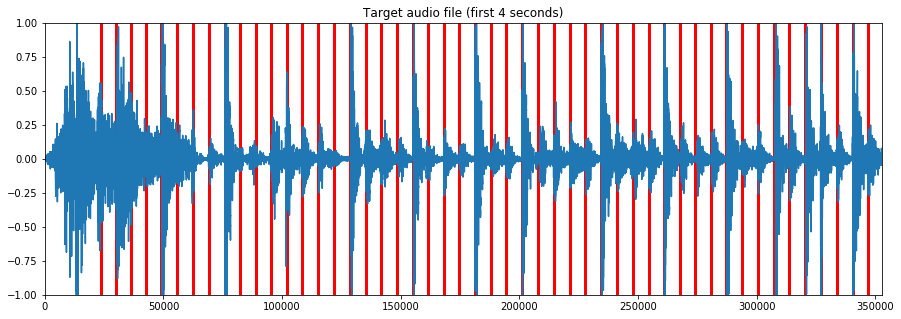

,end_sample,energy,freesound_id,id,key,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,spec_centroid,start_sample
0,29952,131.697815,None,None_f0,Bb,0.675378,0.004111,-680.108032,165.230499,-11.958181,...,0.421124,-3.396658,-8.651056,-2.386759,-1.357698,-2.044317,edited_MISSION.wav,minor,1079.569336,23552
1,36352,453.047516,None,None_f1,Eb,0.743459,0.009407,-577.747620,134.914780,-10.904318,...,10.784868,0.608969,-3.438215,-0.278660,8.170338,8.153629,edited_MISSION.wav,major,1633.404541,29952
2,42752,122.058472,None,None_f2,B,0.646057,0.003907,-713.791016,182.379700,-5.613569,...,22.071102,7.859472,-2.180351,7.622280,1.156940,-2.152756,edited_MISSION.wav,major,490.437683,36352
3,49152,55.974457,None,None_f3,Bb,0.634447,0.002317,-779.055481,179.057922,-5.386843,...,22.060726,2.332390,-3.297239,4.157440,1.457470,-2.251293,edited_MISSION.wav,minor,388.475403,42752
4,55808,801.070618,None,None_f4,G,0.848114,0.013251,-698.999634,143.727325,9.780281,...,29.050583,20.251345,13.488792,10.988878,0.483561,5.694956,edited_MISSION.wav,major,482.568939,49152
5,62464,38.510151,None,None_f5,G,0.629418,0.001734,-766.569092,135.309845,0.364979,...,17.725964,14.782688,4.583462,17.874046,6.473045,11.046206,edited_MISSION.wav,major,1074.340332,55808
6,69120,12.766354,None,None_f6,E,0.614949,0.000828,-957.915344,148.633392,8.493595,...,28.101292,24.808357,23.623844,17.261797,-1.141678,-0.318832,edited_MISSION.wav,minor,868.741699,62464
7,75776,11.360503,None,None_f7,Ab,0.492067,0.000765,-990.837952,159.357697,-13.573263,...,28.405247,22.981041,13.954685,11.236536,10.486668,2.700775,edited_MISSION.wav,minor,381.324463,69120
8,82304,478.065033,None,None_f8,Bb,0.467980,0.009560,-730.300476,163.254852,3.113592,...,19.843365,9.240520,14.119568,11.434458,5.850853,2.219776,edited_MISSION.wav,minor,1148.343384,75776
9,88832,11.551571,None,None_f9,Eb,0.695552,0.000789,-867.695312,136.202042,-1.147488,...,33.912327,15.211111,-9.111208,2.571014,-1.818668,7.275574,edited_MISSION.wav,major,1080.874268,82304


,end_sample,energy,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,spec_centroid,start_sample
count,2.230000e+02,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,2.230000e+02
mean,7.639166e+05,158.092538,0.575329,0.003931,-801.399438,160.319929,-4.388673,-2.621566,-2.478753,31.125637,27.849082,19.341451,11.239106,3.713145,4.505666,3.394729,-1.382322,856.451252,7.573043e+05
std,4.269236e+05,176.079614,0.151633,0.003150,118.234860,29.416816,10.486139,11.218162,7.255751,25.657093,14.463732,11.487548,11.161117,10.330675,9.487936,9.376492,8.610672,480.974024,4.269202e+05
min,2.995200e+04,2.098797,0.196679,0.000247,-1074.231445,82.488533,-37.305073,-44.943871,-22.761158,-40.428493,-14.612137,-14.859167,-18.652977,-19.159142,-20.302471,-20.171432,-27.314156,141.491028,2.355200e+04
25%,3.964800e+05,25.975957,0.476397,0.001338,-893.075531,140.230148,-12.062872,-10.735312,-6.880363,13.149376,17.832305,10.880692,3.915271,-3.033897,-1.595530,-2.245794,-6.165349,493.262299,3.898880e+05
50%,7.628800e+05,76.400368,0.564939,0.002795,-788.285645,157.263733,-4.744427,-1.427317,-2.256004,25.928894,28.467346,19.175678,11.314581,2.568344,4.157440,3.144493,-1.278112,768.056274,7.563520e+05
75%,1.131840e+06,244.289154,0.682209,0.006034,-708.118195,177.220390,3.009961,5.030523,1.874839,50.086767,38.025707,28.079647,18.268543,10.429847,9.322417,9.589649,5.072511,1080.221802,1.125312e+06
max,1.498112e+06,801.070618,0.926222,0.013251,-577.747620,249.421967,24.138561,22.473116,18.741909,88.457642,59.346481,49.119709,39.168674,30.063805,34.720821,33.504608,18.812357,3161.427490,1.491456e+06


In [57]:
TARGET_SOUND_PATH = 'edited_MISSION.wav'
#TARGET_SOUND_PATH = '262350__stereo-surgeon__grinder-drum-loop.wav'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target_exp1_16th.csv'  # DataFrame file where to store the analysis results of the target audio

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))

loader = estd.MonoLoader(filename=TARGET_SOUND_PATH)
audio = loader()

# Calculate BPM 
bpm_algo = estd.RhythmExtractor()
bpm, _, _, _ = bpm_algo(audio)
print(bpm)
#frame_size = int(round(float(60/bpm)*44100) /4)# frame_size = 1/16 note
#print(frame_size)
target_analysis = analyze_Target_sound(TARGET_SOUND_PATH, frame_size_type="sixteenth")  # Also split audio in chunks of 200ms (44100/5 samples) 

df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))



# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red',linewidth = 3)
#plt.vlines(beat_positions, -1, 1, color='r',linewidth=3)
plt.axis([0, min(len(audio), 44100 * 8), -1, 1])
plt.title('Target audio file (first 4 seconds)')
plt.show()

display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame

## Analyze the target sound file Experiment 1， frame_size = 8th note

Analyzing target sound edited_MISSION.wav
100.48737335205078
Saved target dataframe with 111 entries! dataframe_target_exp1_8th.csv


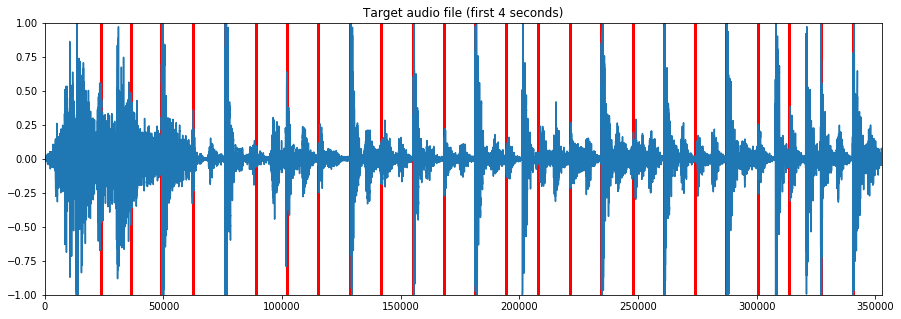

,end_sample,energy,freesound_id,id,key,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,spec_centroid,start_sample
0,36352,584.745972,None,None_f0,Bb,0.672533,0.005580,-599.041443,108.911148,-13.526697,...,9.990284,-5.110178,-0.498577,-1.507065,-0.395365,4.275436,edited_MISSION.wav,minor,1526.268311,23552
1,49152,178.032745,None,None_f1,Bb,0.574610,0.002516,-799.312500,196.035080,-9.331638,...,19.711960,-0.325680,-4.659573,4.672283,1.401253,-6.674358,edited_MISSION.wav,minor,460.809631,36352
2,62464,839.580505,None,None_f2,G,0.831213,0.006837,-788.558472,175.174454,-0.052006,...,26.253555,9.097801,8.518803,10.336979,-0.840336,6.969137,edited_MISSION.wav,major,524.536255,49152
3,75776,24.126869,None,None_f3,Bb,0.381990,0.000634,-912.792847,149.317856,-1.622845,...,23.998035,15.831554,7.384552,12.242249,1.488621,3.607738,edited_MISSION.wav,minor,683.977417,62464
4,88832,489.614014,None,None_f4,Bb,0.385242,0.004857,-855.941956,137.703690,4.151230,...,24.443569,24.492962,5.081226,11.911417,8.970322,1.332802,edited_MISSION.wav,minor,1146.796875,75776
5,101888,142.343338,None,None_f5,F,0.776265,0.002123,-771.382568,132.187317,0.268738,...,27.857281,14.586346,10.977695,0.089268,-4.210722,-7.360361,edited_MISSION.wav,minor,482.729431,88832
6,115200,166.470078,None,None_f6,Bb,0.548527,0.002312,-782.595459,128.321396,-5.531866,...,6.617168,-0.033230,12.119095,18.239780,9.032494,6.564280,edited_MISSION.wav,minor,470.250092,101888
7,128512,26.876160,None,None_f7,Eb,0.661019,0.000681,-1001.830688,147.214630,-2.591663,...,28.961231,25.200592,20.453953,10.810938,0.249313,-6.127655,edited_MISSION.wav,minor,934.853210,115200
8,141824,275.532898,None,None_f8,Bb,0.531082,0.003241,-756.477234,139.964752,-1.123964,...,8.705265,8.355440,4.927963,6.658016,-3.343256,-3.397301,edited_MISSION.wav,minor,1316.409424,128512
9,155136,38.546532,None,None_f9,E,0.544404,0.000868,-885.923035,156.127426,2.136448,...,26.922924,-3.726730,-9.318542,2.766556,-8.958275,5.848288,edited_MISSION.wav,minor,795.366211,141824


,end_sample,energy,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,spec_centroid,start_sample
count,1.110000e+02,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,1.110000e+02
mean,7.639155e+05,317.446307,0.572851,0.003389,-777.121358,149.808000,-4.053204,-0.887149,-2.351962,32.070396,25.905802,15.915928,8.064347,1.018053,3.329575,2.793508,-1.180650,872.249281,7.506912e+05
std,4.259692e+05,208.030539,0.145477,0.001646,74.270180,23.920539,8.276760,9.853331,7.248212,16.900793,11.174445,9.106904,8.882346,9.723798,7.403109,7.382934,7.083123,399.762586,4.259630e+05
min,3.635200e+04,22.017830,0.249866,0.000596,-1001.830688,89.050346,-21.613678,-28.535131,-22.014318,-31.911366,-1.318390,-8.800098,-10.906895,-17.975431,-12.489170,-12.784065,-19.835176,179.127991,2.355200e+04
25%,3.997440e+05,150.315437,0.461454,0.002159,-820.907471,135.039505,-9.224084,-7.214937,-7.777771,21.861866,19.601762,9.896709,1.542560,-6.480834,-2.579374,-2.621133,-5.957644,526.862793,3.865600e+05
50%,7.628800e+05,291.570557,0.565926,0.003410,-784.530090,147.866531,-4.122297,0.865189,-2.244009,31.145584,25.842064,15.264725,7.417656,0.483501,2.766556,2.420738,-1.063208,838.061218,7.498240e+05
75%,1.128576e+06,481.539032,0.681366,0.004730,-732.805359,162.550598,1.626697,6.435803,2.908875,45.412813,33.515984,23.739988,14.607339,7.805041,8.426359,7.132411,3.860878,1163.445435,1.115520e+06
max,1.491456e+06,839.580505,0.888527,0.006837,-599.041443,227.255920,15.862814,18.921696,13.121735,73.071014,58.531540,35.383350,30.256540,28.356449,23.318796,23.289955,15.962949,1765.500977,1.478144e+06


In [58]:
TARGET_SOUND_PATH = 'edited_MISSION.wav'
#TARGET_SOUND_PATH = '262350__stereo-surgeon__grinder-drum-loop.wav'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target_exp1_8th.csv'  # DataFrame file where to store the analysis results of the target audio

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))

loader = estd.MonoLoader(filename=TARGET_SOUND_PATH)
audio = loader()

# Calculate BPM 
bpm_algo = estd.RhythmExtractor()
bpm, _, _, _ = bpm_algo(audio)
print(bpm)
#frame_size = int(round(float(60/bpm)*44100) /4)# frame_size = 1/16 note
#print(frame_size)
target_analysis = analyze_Target_sound(TARGET_SOUND_PATH, frame_size_type="eighth")  # Also split audio in chunks of 200ms (44100/5 samples) 

df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))



# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red',linewidth = 3)
#plt.vlines(beat_positions, -1, 1, color='r',linewidth=3)
plt.axis([0, min(len(audio), 44100 * 8), -1, 1])
plt.title('Target audio file (first 4 seconds)')
plt.show()

display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame

## Experiment 2: Audio mosaicing with similar energy (using Energy feature set)
## Analyze source collection frame_size = 1/16note

In [59]:
DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME = 'dataframe_source_exp2_16th.csv'  # DataFrame file where to store the results of our analysis
TARGET_SOUND_PATH = 'edited_ready_go.wav'
# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME), index_col=0)
analyses = []

loader = estd.MonoLoader(filename=TARGET_SOUND_PATH)
audio = loader()
# Calculate BPM 
bpm_algo = estd.RhythmExtractor()
bpm, _, _, _ = bpm_algo(audio)
print(bpm)

framesize = int(round(float(60/bpm)*44100) /4)# 1/16 note
print(framesize)
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    analysis_output = analyze_sound(sound['path'], frame_size=framesize, audio_id=sound['freesound_id'])  # Split audio in chunks of 200ms (44100/5 samples)
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame


125.59749603271484
5266
Analyzing sound with id 469308 [1/40]
Analyzing sound with id 100759 [2/40]
Analyzing sound with id 220662 [3/40]
Analyzing sound with id 503020 [4/40]
Analyzing sound with id 436782 [5/40]
Analyzing sound with id 85897 [6/40]
Analyzing sound with id 509882 [7/40]
Analyzing sound with id 509885 [8/40]
Analyzing sound with id 220820 [9/40]
Analyzing sound with id 551019 [10/40]
Analyzing sound with id 25602 [11/40]
Analyzing sound with id 509486 [12/40]
Analyzing sound with id 42551 [13/40]
Analyzing sound with id 102785 [14/40]
Analyzing sound with id 132582 [15/40]
Analyzing sound with id 265677 [16/40]
Analyzing sound with id 278984 [17/40]
Analyzing sound with id 410149 [18/40]
Analyzing sound with id 218279 [19/40]
Analyzing sound with id 208871 [20/40]
Analyzing sound with id 82238 [21/40]
Analyzing sound with id 524882 [22/40]
Analyzing sound with id 112462 [23/40]
Analyzing sound with id 154726 [24/40]
Analyzing sound with id 128972 [25/40]
Analyzing soun

,end_sample,energy,freesound_id,id,key,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,spec_centroid,start_sample
0,5266,7.988009e+01,469308,469308_f0,F,0.745652,3.573987e-03,-637.026672,41.624725,-22.731190,...,-33.758080,-10.225639,-57.517036,31.461685,-3.956396,-35.636414,files/469308_2927958-hq.ogg,major,3088.944824,0
1,10532,1.216852e+01,469308,469308_f1,F#,0.672501,1.013044e-03,-866.093506,73.895538,-22.791567,...,-40.898346,3.887154,-39.849098,-2.528580,44.025539,-16.017544,files/469308_2927958-hq.ogg,major,1464.840942,5266
2,15798,5.520456e-01,469308,469308_f2,Eb,0.572033,1.275388e-04,-920.218567,18.566238,-19.118654,...,-9.261345,7.233829,-46.129284,-2.884304,41.716740,-42.347347,files/469308_2927958-hq.ogg,major,3509.937012,10532
3,21064,6.863756e-02,469308,469308_f3,C,0.424078,3.155118e-05,-1009.819336,99.697304,-24.197897,...,18.132080,14.162872,-12.837570,-5.297226,4.045361,-13.948021,files/469308_2927958-hq.ogg,major,1546.582886,15798
4,26330,7.630568e-02,469308,469308_f4,C,0.554404,3.387133e-05,-1002.342651,105.834511,-18.056952,...,-1.323349,10.904236,-8.890800,-6.410629,1.134796,-11.630707,files/469308_2927958-hq.ogg,minor,1265.763306,21064
5,5266,5.945198e+01,100759,100759_f0,E,0.608468,2.932315e-03,-755.844299,116.630173,-11.340401,...,-31.975901,-34.178299,-40.332737,-7.066196,-19.954443,-29.705942,files/100759_321967-hq.ogg,major,1057.372681,0
6,10532,1.719054e+02,100759,100759_f1,C#,0.442754,5.972595e-03,-646.592041,42.507523,20.437931,...,-25.083996,-49.115776,-38.523949,-22.301342,18.695467,0.734797,files/100759_321967-hq.ogg,major,1960.209351,5266
7,15798,3.437730e+01,100759,100759_f2,Eb,0.757449,2.031521e-03,-712.089905,31.335724,-10.383915,...,-44.037735,-34.102913,-16.536190,16.307085,27.750961,-13.512108,files/100759_321967-hq.ogg,minor,2342.830566,10532
8,21064,1.504048e-02,100759,100759_f3,Eb,0.458425,1.140997e-05,-1110.722900,19.451031,-15.881430,...,12.253403,6.603615,3.284855,13.146318,10.865383,-8.915794,files/100759_321967-hq.ogg,minor,3219.942139,15798
9,5266,1.037765e-02,220662,220662_f0,F#,0.309817,8.898265e-06,-1135.767700,3.748119,3.465427,...,3.704758,3.678932,3.647297,3.610107,3.567348,3.519119,files/220662_3824909-hq.ogg,minor,2425.988525,0


,end_sample,energy,freesound_id,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,spec_centroid,start_sample
count,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000
mean,30288.706294,176.296749,286910.213287,0.252605,0.003753,-937.320934,77.355911,1.158830,0.910665,-0.195147,-8.565984,4.317551,0.202385,4.210946,2.331653,2.701125,-0.044401,0.000848,1161.199267,25022.706294
std,21140.941995,470.433360,175569.202732,0.659056,0.007466,200.846593,69.165462,14.462234,13.820268,10.908345,54.532501,35.698910,30.305867,20.497950,19.575015,15.218577,14.940494,17.437730,1306.075993,21140.941995
min,5266.000000,0.000000,25602.000000,-1.000000,0.000000,-1138.420044,-19.712280,-28.054541,-48.356030,-40.454388,-212.273590,-89.064522,-97.896042,-70.908569,-57.517036,-44.842346,-52.555099,-62.792961,0.000000,0.000000
25%,10532.000000,0.001919,137392.000000,0.340544,0.000003,-1131.859711,3.862026,-6.806112,-5.193974,-4.730986,-36.081153,-10.445593,-14.483474,-3.270057,-7.476156,-3.007113,-7.073966,-6.704476,161.519859,5266.000000
50%,26330.000000,1.772273,265677.000000,0.533100,0.000279,-1008.186157,64.171082,-0.000027,-0.000031,-0.000038,-0.000061,0.000080,-0.000061,0.000023,-0.000027,0.033424,-0.000046,-0.000023,878.964111,21064.000000
75%,42128.000000,82.645823,503020.000000,0.672842,0.003656,-754.632843,127.543007,5.916186,5.552597,3.022927,26.430560,23.476966,18.078865,14.456145,14.520749,10.445457,5.490534,6.368002,1620.623474,36862.000000
max,84256.000000,2976.165771,556814.000000,0.926258,0.040352,-453.634521,263.783752,60.716335,45.445724,35.040951,134.501709,128.807068,99.658279,62.734406,57.865517,52.600983,47.126118,64.953537,9288.482422,78990.000000


## Exp2 Analyze the target sound file 

Analyzing target sound edited_ready_go.wav
125.59749603271484
5266
Saved target dataframe with 123 entries! dataframe_target_exp2_16th.csv


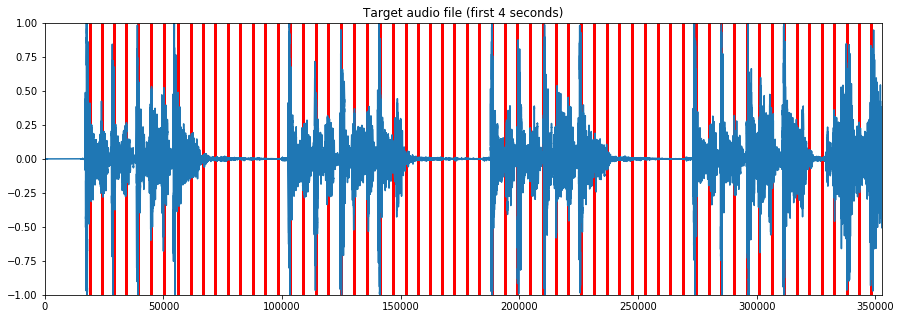

,end_sample,energy,freesound_id,id,key,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,spec_centroid,start_sample
0,24064,59.738319,None,None_f0,C#,0.497360,0.003026,-725.617676,135.088379,2.177528,...,15.820221,22.307728,21.513714,12.153519,-4.953875,0.276752,edited_ready_go.wav,minor,1118.889893,18944
1,29184,242.731903,None,None_f1,Eb,0.521995,0.007740,-779.430542,116.388290,9.588154,...,31.748793,23.142521,14.935314,13.335562,6.196548,6.152767,edited_ready_go.wav,minor,925.411682,24064
2,34304,61.619259,None,None_f2,G,0.294917,0.003089,-725.604736,119.878075,7.978674,...,16.447575,18.372829,16.592180,1.699539,3.862059,8.185846,edited_ready_go.wav,minor,1069.929199,29184
3,39424,304.510162,None,None_f3,C,0.593603,0.009010,-839.618347,129.956375,8.153412,...,20.786770,28.316618,13.341312,10.861670,6.127766,7.815947,edited_ready_go.wav,major,560.599243,34304
4,44928,130.204056,None,None_f4,F,0.659078,0.004744,-802.530273,129.768768,10.023546,...,34.126740,29.376465,17.001781,11.680626,4.436886,3.225128,edited_ready_go.wav,major,1335.618286,39424
5,50432,134.023010,None,None_f5,F#,0.701583,0.004837,-640.714844,89.880379,8.233870,...,17.675772,19.447359,14.066311,8.968777,-7.023026,-20.137341,edited_ready_go.wav,minor,1816.306396,44928
6,55936,458.413361,None,None_f6,Eb,0.455822,0.011025,-681.010071,103.671364,4.240210,...,25.988708,23.399878,24.258757,7.538242,4.850863,4.753935,edited_ready_go.wav,major,918.982727,50432
7,61440,64.367218,None,None_f7,F#,0.301166,0.002959,-677.286377,87.000801,3.828499,...,25.796156,24.682158,17.148909,9.923983,0.611649,11.037325,edited_ready_go.wav,minor,1686.949463,55936
8,66688,18.560066,None,None_f8,F,0.498922,0.001349,-794.615173,144.460617,7.637894,...,32.830658,26.134670,10.879166,2.874901,-1.065170,4.371235,edited_ready_go.wav,minor,634.803955,61440
9,71936,0.986826,None,None_f9,C,0.328832,0.000189,-986.455566,122.107109,-8.819830,...,41.082462,24.720169,27.196205,9.065500,-8.085457,-10.307587,edited_ready_go.wav,minor,459.180725,66688


,end_sample,energy,key_strength,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,spec_centroid,start_sample
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,348160.000000,147.517705,0.566001,0.004724,-781.077729,116.409234,6.738947,3.597575,-3.320608,32.949567,34.219338,22.030159,19.254065,14.257743,11.812765,4.800000,3.252160,1016.753453,342849.560976
std,189371.381104,132.981482,0.136962,0.003399,142.389502,24.342388,7.871304,7.834433,6.490157,20.670595,12.504762,11.283509,9.590137,8.311632,6.344797,8.154564,8.561948,566.079805,189370.498454
min,24064.000000,0.002963,0.279513,0.000004,-1111.578979,36.082073,-17.159966,-19.447023,-23.966095,-18.231503,-10.618309,-9.204424,-7.879795,-13.933554,-3.705456,-12.895559,-20.137341,266.497528,18944.000000
25%,185792.000000,37.278454,0.470115,0.002151,-839.641174,102.975559,0.894169,-0.388658,-7.583614,18.457397,27.636542,15.411985,13.662024,10.396681,7.558098,-0.508497,-2.286822,569.699677,180544.000000
50%,348416.000000,117.850716,0.543543,0.004543,-734.013123,118.993233,7.191280,3.739779,-2.942682,36.262726,35.381691,21.290041,20.796341,16.091801,11.518656,4.436886,2.381315,925.411682,343168.000000
75%,510144.000000,233.501617,0.666303,0.007330,-682.009033,131.163269,10.828590,8.411452,1.174103,50.227943,42.802225,30.204689,25.288908,19.046520,15.976012,9.333222,8.574174,1293.444763,504640.000000
max,672128.000000,465.473511,0.867048,0.011454,-530.741150,191.789795,24.715008,23.715303,12.857170,67.598602,61.365128,46.704216,44.206169,34.799469,26.090317,28.713398,26.019228,3444.932861,666880.000000


In [60]:


TARGET_SOUND_PATH = 'edited_ready_go.wav'
#TARGET_SOUND_PATH = '262350__stereo-surgeon__grinder-drum-loop.wav'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target_exp2_16th.csv'  # DataFrame file where to store the analysis results of the target audio

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))

loader = estd.MonoLoader(filename=TARGET_SOUND_PATH)
audio = loader()

# Calculate BPM 
bpm_algo = estd.RhythmExtractor()
bpm, _, _, _ = bpm_algo(audio)
print(bpm)
frame_size = int(round(float(60/bpm)*44100) /4)# frame_size = 1/16 note
print(frame_size)
target_analysis = analyze_Target_sound(TARGET_SOUND_PATH, frame_size_type='sixteenth')  # Also split audio in chunks of 200ms (44100/5 samples) 

df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))



# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red',linewidth = 3)
#plt.vlines(beat_positions, -1, 1, color='r',linewidth=3)
plt.axis([0, min(len(audio), 44100 * 8), -1, 1])
plt.title('Target audio file (first 4 seconds)')
plt.show()

display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame